
#  Install Transformers + Accelerate



In [1]:
!pip install -q transformers datasets accelerate evaluate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


# Imports

In [9]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch


[codecarbon INFO @ 08:15:45] Energy consumed for RAM : 0.000164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:15:45] Delta energy consumed for CPU with constant : 0.000023 kWh, power : 42.5 W
[codecarbon INFO @ 08:15:45] Energy consumed for All CPU : 0.000702 kWh
[codecarbon INFO @ 08:15:45] Energy consumed for all GPUs : 0.000167 kWh. Total GPU Power : 10.263103383403491 W
[codecarbon INFO @ 08:15:45] 0.001033 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:15:46] Energy consumed for RAM : 0.000167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:15:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:15:46] Energy consumed for All CPU : 0.000713 kWh
[codecarbon INFO @ 08:15:46] Energy consumed for all GPUs : 0.000170 kWh. Total GPU Power : 10.024401713776657 W
[codecarbon INFO @ 08:15:46] 0.001050 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:

# unzipping the data

In [4]:
import zipfile
import os

zip_file_path = '/content/doculizer_dataset (1).zip'

# Get the directory of the zip file
output_directory = os.path.dirname(zip_file_path)

# If the output directory is empty (i.e., zip_file_path is just a file name with no path),
# default to the current directory.
if not output_directory:
    output_directory = '.' # Current directory

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_directory)

print(f"Successfully unzipped '{zip_file_path}' to '{output_directory}'")

Successfully unzipped '/content/doculizer_dataset (1).zip' to '/content'


# Load the Dataset

In [5]:
import pandas as pd

# 1) Load dataset
df = pd.read_csv("/content/dataset.csv")

# 2) Keep only what we need
df = df[["abstract", "label"]]

# 3) Map string labels to ints
df["label"] = df["label"].map({"not_nlp": 0, "nlp_related": 1})

# 4) Drop any rows with missing values (just in case)
df = df.dropna(subset=["abstract", "label"])

# 5) Shuffle + reset index
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

df.head(), df["label"].value_counts()


(                                            abstract  label
 0  Investigating the interaction of electrons in ...      0
 1  As NLP models become more integrated with the ...      1
 2  The harmonic polytope and the bipermutahedron ...      0
 3  We proposed social synergetics and the four ba...      0
 4  A contribution is presented to the application...      0,
 label
 0    1200
 1    1200
 Name: count, dtype: int64)

# split the dataset

In [6]:
from datasets import Dataset

# Convert pandas → HF Dataset
hf_dataset = Dataset.from_pandas(df)

# First: train + test
splits = hf_dataset.train_test_split(test_size=0.20, seed=42)

# Second: split train (train + val)
train_val = splits["train"].train_test_split(test_size=0.15, seed=42)

train_ds = train_val["train"]
val_ds   = train_val["test"]
test_ds  = splits["test"]

len(train_ds), len(val_ds), len(test_ds)


[codecarbon INFO @ 08:15:14] Energy consumed for RAM : 0.000080 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:15:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:15:14] Energy consumed for All CPU : 0.000342 kWh
[codecarbon INFO @ 08:15:14] Energy consumed for all GPUs : 0.000081 kWh. Total GPU Power : 9.905995450153599 W
[codecarbon INFO @ 08:15:14] 0.000503 kWh of electricity and 0.000000 L of water were used since the beginning.


(1632, 288, 480)

# Carbon

In [3]:
import os
!pip install codecarbon
from codecarbon import EmissionsTracker


os.makedirs("carbon_reports", exist_ok=True)

tracker = EmissionsTracker(
    output_dir="carbon_reports",
    output_file="scibert_training_emissions.csv",
    measure_power_secs=1,
)

tracker.start()


[codecarbon WARNING @ 08:14:43] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 08:14:43] [setup] RAM Tracking...
[codecarbon INFO @ 08:14:43] [setup] CPU Tracking...
[codecarbon WARNING @ 08:14:44] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 08:14:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 08:14:44] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 08:14:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 08:14:44] [setup] GPU Tracking...
[codecarbon INFO @ 08:14:44] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 08:14:44] The below tracking methods have been set up:
                RAM Tracking Method: RAM po

# Load SciBERT Tokenizer

In [7]:
from transformers import AutoTokenizer

model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["abstract"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

train_tokenized = train_ds.map(tokenize, batched=True)
val_tokenized   = val_ds.map(tokenize, batched=True)
test_tokenized  = test_ds.map(tokenize, batched=True)


[codecarbon INFO @ 08:15:21] Energy consumed for RAM : 0.000099 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:15:21] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 08:15:21] Energy consumed for All CPU : 0.000423 kWh
[codecarbon INFO @ 08:15:21] Energy consumed for all GPUs : 0.000101 kWh. Total GPU Power : 10.058161532787777 W
[codecarbon INFO @ 08:15:21] 0.000623 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:15:22] Energy consumed for RAM : 0.000102 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:15:22] Delta energy consumed for CPU with constant : 0.000014 kWh, power : 42.5 W
[codecarbon INFO @ 08:15:22] Energy consumed for All CPU : 0.000437 kWh
[codecarbon INFO @ 08:15:22] Energy consumed for all GPUs : 0.000104 kWh. Total GPU Power : 10.578873211129704 W
[codecarbon INFO @ 08:15:22] 0.000643 kWh of electricity and 0.000000 L of water were used since the beginning.


Map:   0%|          | 0/1632 [00:00<?, ? examples/s]

[codecarbon INFO @ 08:15:23] Energy consumed for RAM : 0.000105 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:15:23] Delta energy consumed for CPU with constant : 0.000010 kWh, power : 42.5 W
[codecarbon INFO @ 08:15:23] Energy consumed for All CPU : 0.000447 kWh
[codecarbon INFO @ 08:15:23] Energy consumed for all GPUs : 0.000107 kWh. Total GPU Power : 9.837712095664859 W
[codecarbon INFO @ 08:15:23] 0.000659 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:15:24] Energy consumed for RAM : 0.000107 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:15:24] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 08:15:24] Energy consumed for All CPU : 0.000459 kWh
[codecarbon INFO @ 08:15:24] Energy consumed for all GPUs : 0.000109 kWh. Total GPU Power : 9.82323497646467 W
[codecarbon INFO @ 08:15:24] 0.000675 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:15:

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

[codecarbon INFO @ 08:15:26] Energy consumed for RAM : 0.000113 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:15:26] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 08:15:26] Energy consumed for All CPU : 0.000481 kWh
[codecarbon INFO @ 08:15:26] Energy consumed for all GPUs : 0.000115 kWh. Total GPU Power : 10.56277244062623 W
[codecarbon INFO @ 08:15:26] 0.000708 kWh of electricity and 0.000000 L of water were used since the beginning.


# Prepare SciBERT Model

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

model.to("cuda")


[codecarbon INFO @ 08:16:07] Energy consumed for RAM : 0.000223 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:07] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:07] Energy consumed for All CPU : 0.000953 kWh
[codecarbon INFO @ 08:16:07] Energy consumed for all GPUs : 0.000228 kWh. Total GPU Power : 10.110443557214262 W
[codecarbon INFO @ 08:16:07] 0.001404 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:16:07] 0.005845 g.CO2eq/s mean an estimation of 184.3326561842617 kg.CO2eq/year
[codecarbon INFO @ 08:16:08] Energy consumed for RAM : 0.000226 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:08] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:08] Energy consumed for All CPU : 0.000965 kWh
[codecarbon INFO @ 08:16:08] Energy consumed for all GPUs : 0.000230 kWh. Total GPU Power : 9.938894500667848 W
[codecarbon INFO @ 08:16:08] 0.00

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Define Metrics

In [11]:
import evaluate
f1_metric = evaluate.load("f1")
acc_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    f1 = f1_metric.compute(predictions=preds, references=labels, average="binary")
    acc = acc_metric.compute(predictions=preds, references=labels)
    return {
        "accuracy": acc["accuracy"],
        "f1": f1["f1"]
    }


[codecarbon INFO @ 08:16:14] Energy consumed for RAM : 0.000242 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:14] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:14] Energy consumed for All CPU : 0.001035 kWh
[codecarbon INFO @ 08:16:14] Energy consumed for all GPUs : 0.000270 kWh. Total GPU Power : 26.65197624844483 W
[codecarbon INFO @ 08:16:14] 0.001547 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:16:15] Energy consumed for RAM : 0.000245 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:15] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:15] Energy consumed for All CPU : 0.001046 kWh
[codecarbon INFO @ 08:16:15] Energy consumed for all GPUs : 0.000278 kWh. Total GPU Power : 27.871616133399602 W
[codecarbon INFO @ 08:16:15] 0.001568 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:1

# Training Arguments

In [13]:
!pip install -U transformers accelerate datasets



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 20.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [12]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./scibert_classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    do_eval=True,
    logging_dir="./logs",
)


[codecarbon INFO @ 08:16:21] Energy consumed for RAM : 0.000261 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:21] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:21] Energy consumed for All CPU : 0.001115 kWh
[codecarbon INFO @ 08:16:21] Energy consumed for all GPUs : 0.000323 kWh. Total GPU Power : 27.241394097507847 W
[codecarbon INFO @ 08:16:21] 0.001699 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:16:22] Energy consumed for RAM : 0.000264 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:22] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:22] Energy consumed for All CPU : 0.001127 kWh
[codecarbon INFO @ 08:16:22] Energy consumed for all GPUs : 0.000331 kWh. Total GPU Power : 29.346420502878384 W
[codecarbon INFO @ 08:16:22] 0.001722 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:

# training

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
)


/tmp/ipython-input-1928131846.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[codecarbon WARNING @ 08:16:32] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 08:16:32] [setup] RAM Tracking...
[codecarbon INFO @ 08:16:32] [setup] CPU Tracking...
[codecarbon INFO @ 08:16:33] Energy consumed for RAM : 0.000293 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:33] Energy consumed for All CPU : 0.001253 kWh
[codecarbon INFO @ 08:16:33] Energy consumed for all GPUs : 0.000414 kWh. Total GPU Power : 27.257947781064736 W
[codecarbon INFO @ 08:16:33] 0.001961 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 08:16:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Plea

In [14]:
import os
os.environ["WANDB_DISABLED"] = "true"

trainer.train()


[codecarbon INFO @ 08:16:43] Energy consumed for RAM : 0.000319 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:43] Delta energy consumed for CPU with constant : 0.000018 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:43] Energy consumed for All CPU : 0.001364 kWh
[codecarbon INFO @ 08:16:43] Energy consumed for all GPUs : 0.000486 kWh. Total GPU Power : 26.72330133541614 W
[codecarbon INFO @ 08:16:43] 0.002170 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:16:44] Energy consumed for RAM : 0.000322 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:44] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:44] Energy consumed for All CPU : 0.001376 kWh
[codecarbon INFO @ 08:16:44] Energy consumed for all GPUs : 0.000494 kWh. Total GPU Power : 27.531014093989278 W
[codecarbon INFO @ 08:16:44] 0.002192 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:1

 3


wandb: You chose "Don't visualize my results"
[codecarbon INFO @ 08:16:55] Energy consumed for RAM : 0.000352 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:55] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:55] Energy consumed for All CPU : 0.001504 kWh
[codecarbon INFO @ 08:16:55] Energy consumed for all GPUs : 0.000578 kWh. Total GPU Power : 27.44821423911855 W
[codecarbon INFO @ 08:16:55] 0.002434 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:16:56] Energy consumed for RAM : 0.000355 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:56] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:56] Energy consumed for All CPU : 0.001516 kWh
[codecarbon INFO @ 08:16:56] Energy consumed for all GPUs : 0.000585 kWh. Total GPU Power : 27.46493994361596 W
[codecarbon INFO @ 08:16:56] 0.002456 kWh of electricity and 0.000000 L of water were used

[codecarbon INFO @ 08:16:57] Energy consumed for RAM : 0.000357 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:57] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:57] Energy consumed for All CPU : 0.001527 kWh
[codecarbon INFO @ 08:16:57] Energy consumed for all GPUs : 0.000593 kWh. Total GPU Power : 27.7899090461435 W
[codecarbon INFO @ 08:16:57] 0.002477 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:16:58] Energy consumed for RAM : 0.000360 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:58] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:58] Energy consumed for All CPU : 0.001539 kWh
[codecarbon INFO @ 08:16:58] Energy consumed for all GPUs : 0.000601 kWh. Total GPU Power : 28.814990234766807 W
[codecarbon INFO @ 08:16:58] 0.002500 kWh of electricity and 0.000000 L of water were used since the beginning.


Step,Training Loss
500,0.039700


[codecarbon INFO @ 08:16:59] Energy consumed for RAM : 0.000363 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:16:59] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:16:59] Energy consumed for All CPU : 0.001550 kWh
[codecarbon INFO @ 08:16:59] Energy consumed for all GPUs : 0.000614 kWh. Total GPU Power : 46.78150844483945 W
[codecarbon INFO @ 08:16:59] 0.002527 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:17:00] Energy consumed for RAM : 0.000365 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:17:00] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:17:00] Energy consumed for All CPU : 0.001562 kWh
[codecarbon INFO @ 08:17:00] Energy consumed for all GPUs : 0.000633 kWh. Total GPU Power : 69.97930687471836 W
[codecarbon INFO @ 08:17:00] 0.002561 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:17

TrainOutput(global_step=612, training_loss=0.03248368876261844, metrics={'train_runtime': 117.1096, 'train_samples_per_second': 41.807, 'train_steps_per_second': 5.226, 'total_flos': 161023965880320.0, 'train_loss': 0.03248368876261844, 'epoch': 3.0})

# testing

In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

preds = trainer.predict(test_tokenized)
logits = preds.predictions
labels = preds.label_ids

y_pred = np.argmax(logits, axis=1)

print(classification_report(labels, y_pred, target_names=["not_nlp", "nlp_related"]))


[codecarbon INFO @ 08:18:40] Energy consumed for RAM : 0.000638 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:18:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:18:40] Energy consumed for All CPU : 0.002724 kWh
[codecarbon INFO @ 08:18:40] Energy consumed for all GPUs : 0.002205 kWh. Total GPU Power : 31.556722882119825 W
[codecarbon INFO @ 08:18:40] 0.005567 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 08:18:40] 0.008011 g.CO2eq/s mean an estimation of 252.63872472394297 kg.CO2eq/year


[codecarbon INFO @ 08:18:41] Energy consumed for RAM : 0.000641 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:18:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 08:18:41] Energy consumed for All CPU : 0.002736 kWh
[codecarbon INFO @ 08:18:41] Energy consumed for all GPUs : 0.002222 kWh. Total GPU Power : 60.93868642208588 W
[codecarbon INFO @ 08:18:41] 0.005599 kWh of electricity and 0.000000 L of water were used since the beginning.


              precision    recall  f1-score   support

     not_nlp       0.99      0.99      0.99       255
 nlp_related       0.99      0.99      0.99       225

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



In [16]:
tracker.stop()

[codecarbon INFO @ 08:18:42] Energy consumed for RAM : 0.000643 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 08:18:42] Delta energy consumed for CPU with constant : 0.000009 kWh, power : 42.5 W
[codecarbon INFO @ 08:18:42] Energy consumed for All CPU : 0.002745 kWh
[codecarbon INFO @ 08:18:42] Energy consumed for all GPUs : 0.002238 kWh. Total GPU Power : 71.43494821505139 W
[codecarbon INFO @ 08:18:42] 0.005626 kWh of electricity and 0.000000 L of water were used since the beginning.


0.0019647146528990653

# Confusion Matrix

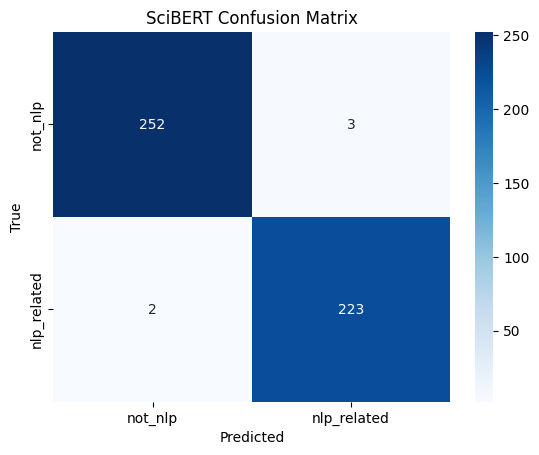

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["not_nlp", "nlp_related"],
            yticklabels=["not_nlp", "nlp_related"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SciBERT Confusion Matrix")
plt.show()


In [35]:
train_preds = trainer.predict(train_tokenized)
train_labels = train_preds.label_ids
train_y_pred = train_preds.predictions.argmax(axis=1)

print("TRAIN REPORT:")
print(classification_report(train_labels, train_y_pred, target_names=["not_nlp", "nlp_related"]))


TRAIN REPORT:
              precision    recall  f1-score   support

     not_nlp       1.00      1.00      1.00       795
 nlp_related       1.00      1.00      1.00       837

    accuracy                           1.00      1632
   macro avg       1.00      1.00      1.00      1632
weighted avg       1.00      1.00      1.00      1632



In [36]:
val_preds = trainer.predict(val_tokenized)
val_labels = val_preds.label_ids
val_y_pred = val_preds.predictions.argmax(axis=1)

print("VALIDATION REPORT:")
print(classification_report(val_labels, val_y_pred, target_names=["not_nlp", "nlp_related"]))


VALIDATION REPORT:
              precision    recall  f1-score   support

     not_nlp       0.99      0.99      0.99       150
 nlp_related       0.99      0.99      0.99       138

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



In [37]:
test_preds = trainer.predict(test_tokenized)
test_labels = test_preds.label_ids
test_y_pred = test_preds.predictions.argmax(axis=1)

print("TEST REPORT:")
print(classification_report(test_labels, test_y_pred, target_names=["not_nlp", "nlp_related"]))


TEST REPORT:
              precision    recall  f1-score   support

     not_nlp       0.99      0.99      0.99       255
 nlp_related       0.99      0.99      0.99       225

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



# **more readabale eval**

In [38]:
from sklearn.metrics import classification_report
import pandas as pd

def extract_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1-score": report["weighted avg"]["f1-score"],
        "accuracy": report["accuracy"]
    }

# Train
train_metrics = extract_metrics(train_labels, train_y_pred)

# Validation
val_metrics = extract_metrics(val_labels, val_y_pred)

# Test
test_metrics = extract_metrics(test_labels, test_y_pred)

# Build comparison table
comparison_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1-score", "Accuracy"],
    "Train": [
        train_metrics["precision"],
        train_metrics["recall"],
        train_metrics["f1-score"],
        train_metrics["accuracy"]
    ],
    "Validation": [
        val_metrics["precision"],
        val_metrics["recall"],
        val_metrics["f1-score"],
        val_metrics["accuracy"]
    ],
    "Test": [
        test_metrics["precision"],
        test_metrics["recall"],
        test_metrics["f1-score"],
        test_metrics["accuracy"]
    ]
})

comparison_df


,Metric,Train,Validation,Test
0,Precision,1.0,0.993056,0.989595
1,Recall,1.0,0.993056,0.989583
2,F1-score,1.0,0.993056,0.989585
3,Accuracy,1.0,0.993056,0.989583


# Save the model as zip

In [39]:
trainer.save_model("./scibert_nlp_classifier")
tokenizer.save_pretrained("./scibert_nlp_classifier")


('./scibert_nlp_classifier/tokenizer_config.json',
 './scibert_nlp_classifier/special_tokens_map.json',
 './scibert_nlp_classifier/vocab.txt',
 './scibert_nlp_classifier/added_tokens.json',
 './scibert_nlp_classifier/tokenizer.json')

In [41]:
import shutil

zip_path = shutil.make_archive('scibert_nlp_classifier', 'zip', '/content/scibert_nlp_classifier')
zip_path



'/content/scibert_nlp_classifier.zip'